**This notebook contains followings:**
* Data Merging
* Feature Extraction
* Model Selection
* Hyperparameter Tuning
* Results on All Datasets
* References
* Conclusion
* Additional Resources


In [1]:
#importing necessary libraries
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import scipy
from scipy.stats import entropy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score
from sklearn import preprocessing
import xgboost as xgb
import catboost as cb
import lightgbm as lgbm
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import plotly.express as px
import plotly.graph_objects as go
import optuna

# Merging Data

In [2]:
#Data paths
dataset_path_1st = '../input/bearing-dataset/1st_test/1st_test'
dataset_path_2nd = '../input/bearing-dataset/2nd_test/2nd_test'
dataset_path_3rd = '../input/bearing-dataset/3rd_test/4th_test/txt'

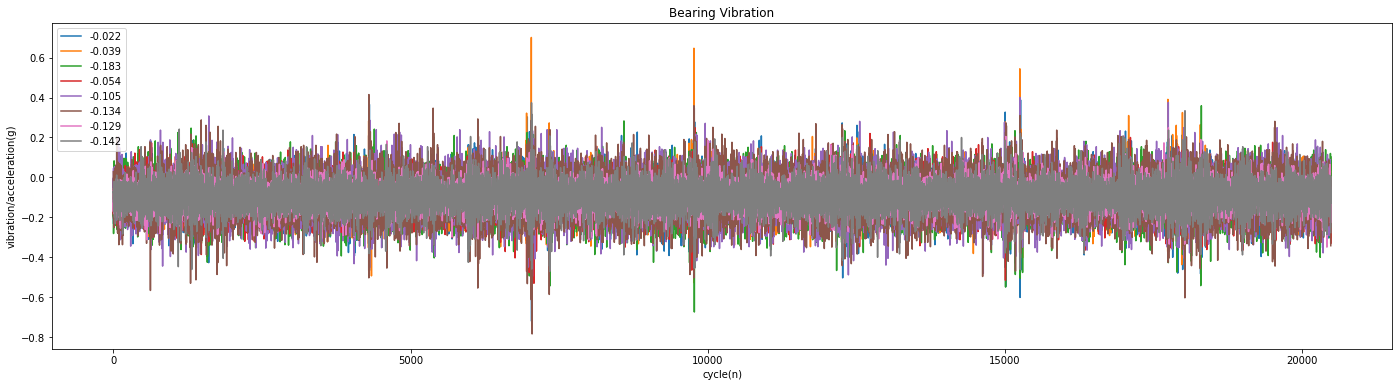

In [3]:
# Test for the first file
dataset = pd.read_csv('../input/bearing-dataset/1st_test/1st_test/2003.10.22.12.06.24', sep='\t')
ax = dataset.plot(figsize = (24,6), title= "Bearing Vibration" , legend = True)
ax.set(xlabel="cycle(n)", ylabel="vibration/acceleration(g)")
plt.show()

# Feature Extraction #

In this section several signal-based statistical features has been extracted from the data                                 
**Definition and formula of the features:**
* ***Absolute Mean*** $$\overline{x} = \frac{1}{N}\sum_{i=1}^{N}|x_i| $$

* ***Standart Deviation:*** $$\sigma         = \sqrt{\frac{1}{N}\sum_{i=1}^{N}(x_i - \overline{x})^2}$$
* ***Skewness:*** 
Asymmetry of a signal distribution. Faults can impact distribution symmetry and therefore increase the level of skewness.
$$\mathrm{Sk} = \frac{1}{N}\sum_{i=1}^{N}\frac{(x_i-\overline{x})^3}{\sigma^3}$$
* ***Kurtosis:***
Length of the tails of a signal distribution, or equivalently, how outlier prone the signal is. Developing faults can increase the number of outliers, and therefore increase the value of the kurtosis metric.
$$\mathrm{K} = \frac{1}{N}\sum_{i=1}^{N}\frac{(x_i-\overline{x})^4}{\sigma^4}$$
* ***Entropy:***$$ H(X) = -\sum_{i=1}^{N} P(x_i)\log{P(x_i)} $$
                            
* ***RMS:*** $$x_{rms} =\sqrt{(\frac{1}{N})\sum_{i=1}^{N}(x)^{2}}$$

* ***Peak to Peak:*** $$ x_p = \max \mathrm{value} - \min \mathrm{value}$$

* ***Crest Factor:*** 
Peak value divided by the RMS. Faults often first manifest themselves in changes in the peakiness of a signal before they manifest in the energy represented by the signal root mean squared. The crest factor can provide an early warning for faults when they first develop. 
$$x_{crest} =\frac{\max \mathrm{value}}{\mathrm{x_{rms}}}$$

* ***Clearence Factor:*** 
Peak value divided by the squared mean value of the square roots of the absolute amplitudes. For rotating machinery, this feature is maximum for healthy bearings and goes on decreasing for defective ball, defective outer race, and defective inner race respectively. The clearance factor has the highest separation ability for defective inner race faults.
$$ x_{clear} = \frac{x_p}{(\frac{1}{N}\sum_{i=1}^{N}\sqrt{|x_i|})^2}  $$

* ***Shape Factor:*** 
RMS divided by the mean of the absolute value. Shape factor is dependent on the signal shape while being independent of the signal dimensions.
$$\frac{x_{rms}}{\overline{x}}$$

* ***Impulse:*** 
Compare the height of a peak to the mean level of the signal.
$$\frac{\max \mathrm{value}}{\overline{x}}  $$


In [4]:
# Root Mean Squared Sum
def calculate_rms(df):
    result = []
    for col in df:
        r = np.sqrt((df[col]**2).sum() / len(df[col]))
        result.append(r)
    return result

# extract peak-to-peak features
def calculate_p2p(df):
    return np.array(df.max().abs() + df.min().abs())

# extract shannon entropy (cut signals to 500 bins)
def calculate_entropy(df):
    ent = []
    for col in df:
        ent.append(entropy(pd.cut(df[col], 500).value_counts()))
    return np.array(ent)
# extract clearence factor
def calculate_clearence(df):
    result = []
    for col in df:
        r = ((np.sqrt(df[col].abs())).sum() / len(df[col]))**2
        result.append(r)
    return result

def time_features(dataset_path, id_set=None):
    time_features = ['mean','std','skew','kurtosis','entropy','rms','max','p2p', 'crest', 'clearence', 'shape', 'impulse']
    cols1 = ['B1_x','B1_y','B2_x','B2_y','B3_x','B3_y','B4_x','B4_y']
    cols2 = ['B1','B2','B3','B4']
    
    # initialize
    if id_set == 1:
        columns = [c+'_'+tf for c in cols1 for tf in time_features]
        data = pd.DataFrame(columns=columns)
    else:
        columns = [c+'_'+tf for c in cols2 for tf in time_features]
        data = pd.DataFrame(columns=columns)

        
        
    for filename in os.listdir(dataset_path):
        # read dataset
        raw_data = pd.read_csv(os.path.join(dataset_path, filename), sep='\t')
        
        # time features
        mean_abs = np.array(raw_data.abs().mean())
        std = np.array(raw_data.std())
        skew = np.array(raw_data.skew())
        kurtosis = np.array(raw_data.kurtosis())
        entropy = calculate_entropy(raw_data)
        rms = np.array(calculate_rms(raw_data))
        max_abs = np.array(raw_data.abs().max())
        p2p = calculate_p2p(raw_data)
        crest = max_abs/rms
        clearence = np.array(calculate_clearence(raw_data))
        shape = rms / mean_abs
        impulse = max_abs / mean_abs
        
        if id_set == 1:
            mean_abs = pd.DataFrame(mean_abs.reshape(1,8), columns=[c+'_mean' for c in cols1])
            std = pd.DataFrame(std.reshape(1,8), columns=[c+'_std' for c in cols1])
            skew = pd.DataFrame(skew.reshape(1,8), columns=[c+'_skew' for c in cols1])
            kurtosis = pd.DataFrame(kurtosis.reshape(1,8), columns=[c+'_kurtosis' for c in cols1])
            entropy = pd.DataFrame(entropy.reshape(1,8), columns=[c+'_entropy' for c in cols1])
            rms = pd.DataFrame(rms.reshape(1,8), columns=[c+'_rms' for c in cols1])
            max_abs = pd.DataFrame(max_abs.reshape(1,8), columns=[c+'_max' for c in cols1])
            p2p = pd.DataFrame(p2p.reshape(1,8), columns=[c+'_p2p' for c in cols1])
            crest = pd.DataFrame(crest.reshape(1,8), columns=[c+'_crest' for c in cols1])
            clearence = pd.DataFrame(clearence.reshape(1,8), columns=[c+'_clearence' for c in cols1])
            shape = pd.DataFrame(shape.reshape(1,8), columns=[c+'_shape' for c in cols1])
            impulse = pd.DataFrame(impulse.reshape(1,8), columns=[c+'_impulse' for c in cols1])
            
        else:
            mean_abs = pd.DataFrame(mean_abs.reshape(1,4), columns=[c+'_mean' for c in cols2])
            std = pd.DataFrame(std.reshape(1,4), columns=[c+'_std' for c in cols2])
            skew = pd.DataFrame(skew.reshape(1,4), columns=[c+'_skew' for c in cols2])
            kurtosis = pd.DataFrame(kurtosis.reshape(1,4), columns=[c+'_kurtosis' for c in cols2])
            entropy = pd.DataFrame(entropy.reshape(1,4), columns=[c+'_entropy' for c in cols2])
            rms = pd.DataFrame(rms.reshape(1,4), columns=[c+'_rms' for c in cols2])
            max_abs = pd.DataFrame(max_abs.reshape(1,4), columns=[c+'_max' for c in cols2])
            p2p = pd.DataFrame(p2p.reshape(1,4), columns=[c+'_p2p' for c in cols2])
            crest = pd.DataFrame(crest.reshape(1,4), columns=[c+'_crest' for c in cols2])
            clearence = pd.DataFrame(clearence.reshape(1,4), columns=[c+'_clearence' for c in cols2])
            shape = pd.DataFrame(shape.reshape(1,4), columns=[c+'_shape' for c in cols2])
            impulse = pd.DataFrame(impulse.reshape(1,4), columns=[c+'_impulse' for c in cols2])
            
        mean_abs.index = [filename]
        std.index = [filename]
        skew.index = [filename]
        kurtosis.index = [filename]
        entropy.index = [filename]
        rms.index = [filename]
        max_abs.index = [filename]
        p2p.index = [filename]
        crest.index = [filename]
        clearence.index = [filename]
        shape.index = [filename]
        impulse.index = [filename] 
        
        # concat
        merge = pd.concat([mean_abs, std, skew, kurtosis, entropy, rms, max_abs, p2p,crest,clearence, shape, impulse], axis=1)
        data = data.append(merge)
        
    if id_set == 1:
        cols = [c+'_'+tf for c in cols1 for tf in time_features]
        data = data[cols]
    else:
        cols = [c+'_'+tf for c in cols2 for tf in time_features]
        data = data[cols]
        
    data.index = pd.to_datetime(data.index, format='%Y.%m.%d.%H.%M.%S')
    data = data.sort_index()
    return data                                  

1.  Calling feature extraction function defined above to merge extracted features      
2.  Saving as .csv file

In [5]:
set1 = time_features(dataset_path_1st, id_set=1)
set1.to_csv('set1_timefeatures.csv')

Reading Data again

In [6]:
set1 = pd.read_csv("./set1_timefeatures.csv")

Changing indexing column to time which is also name of the each file

In [7]:
set1 = set1.rename(columns={'Unnamed: 0':'time'})
set1.set_index('time')
set1.describe()

,B1_x_mean,B1_x_std,B1_x_skew,B1_x_kurtosis,B1_x_entropy,B1_x_rms,B1_x_max,B1_x_p2p,B1_x_crest,B1_x_clearence,...,B4_y_skew,B4_y_kurtosis,B4_y_entropy,B4_y_rms,B4_y_max,B4_y_p2p,B4_y_crest,B4_y_clearence,B4_y_shape,B4_y_impulse
count,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,...,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000
mean,0.127485,0.098575,-0.038621,0.998634,4.981065,0.152221,0.726346,1.177997,4.774991,0.111784,...,0.027031,2.164625,4.842208,0.148647,0.761834,1.314533,4.983898,0.110994,1.183745,5.952366
std,0.006072,0.005345,0.030224,0.197405,0.074409,0.007184,0.079033,0.107634,0.500902,0.005428,...,0.084643,3.346159,0.190066,0.019972,0.395722,0.713627,1.876039,0.010863,0.038067,2.498653
min,0.103651,0.079417,-0.137060,0.279887,4.507776,0.123812,0.510000,0.822000,3.667188,0.090784,...,-1.052182,0.482399,3.715214,0.088486,0.430000,0.681000,2.815276,0.058448,1.055297,2.970951
25%,0.127830,0.096967,-0.058600,0.868275,4.936962,0.152206,0.669000,1.104000,4.407653,0.112297,...,-0.006286,1.045699,4.793158,0.138649,0.547000,0.922000,4.014222,0.107784,1.158352,4.661760
50%,0.128906,0.099051,-0.038491,0.996362,4.983200,0.153733,0.720000,1.175500,4.712466,0.113093,...,0.024396,1.347742,4.869912,0.141205,0.610000,1.062000,4.390117,0.109048,1.165705,5.138212
75%,0.129829,0.101153,-0.017578,1.124417,5.027213,0.155259,0.776000,1.250000,5.063995,0.113818,...,0.060058,1.889175,4.912165,0.159873,0.833500,1.430250,5.088637,0.115484,1.215412,6.147247
max,0.142147,0.129748,0.071573,1.700413,5.304080,0.174977,1.042000,1.533000,7.123639,0.122149,...,1.076577,56.379136,5.335049,0.234521,3.801000,7.122000,19.173531,0.213670,1.386364,25.364433


Plotting features of all bearings in both x and y axis

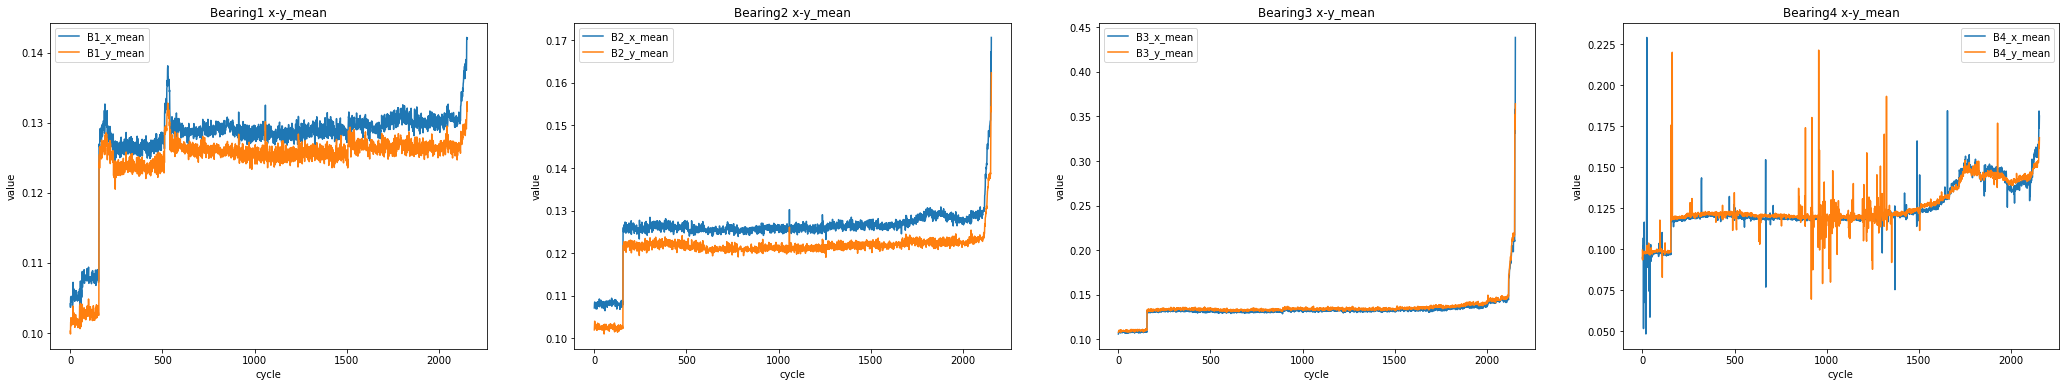

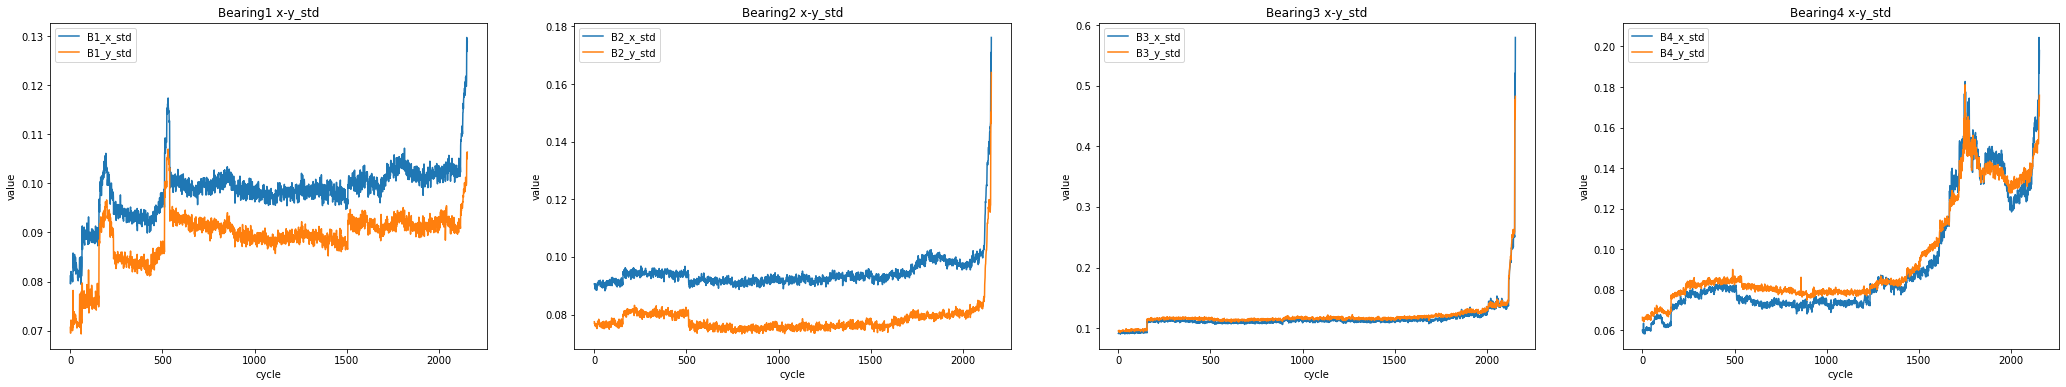

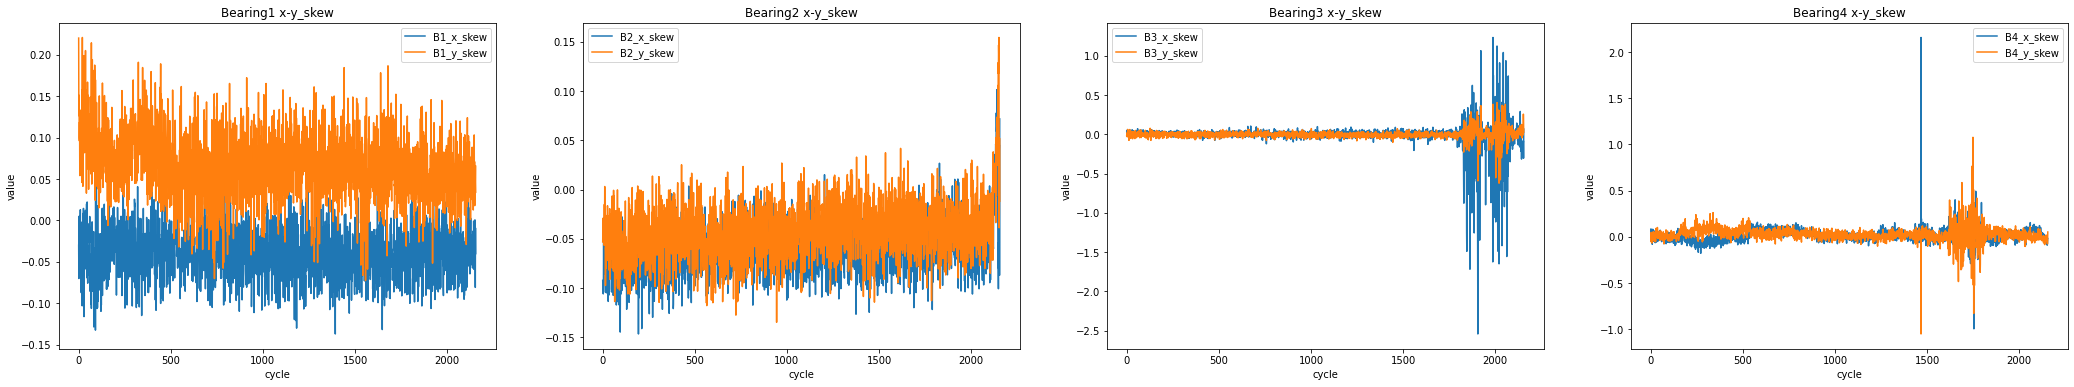

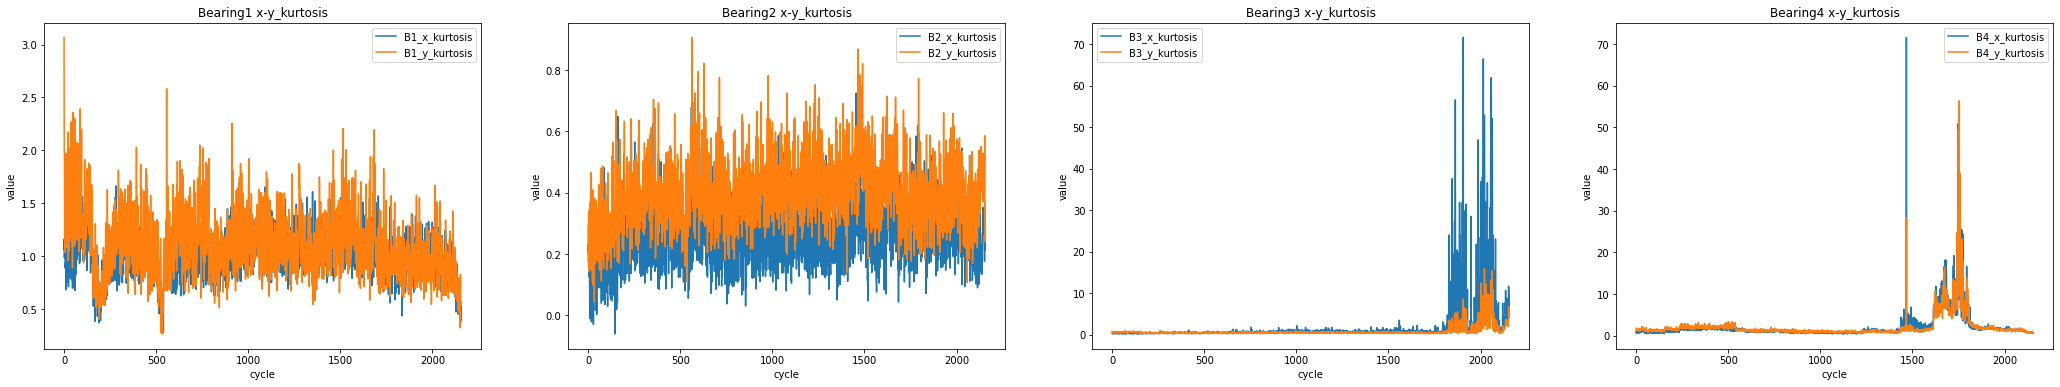

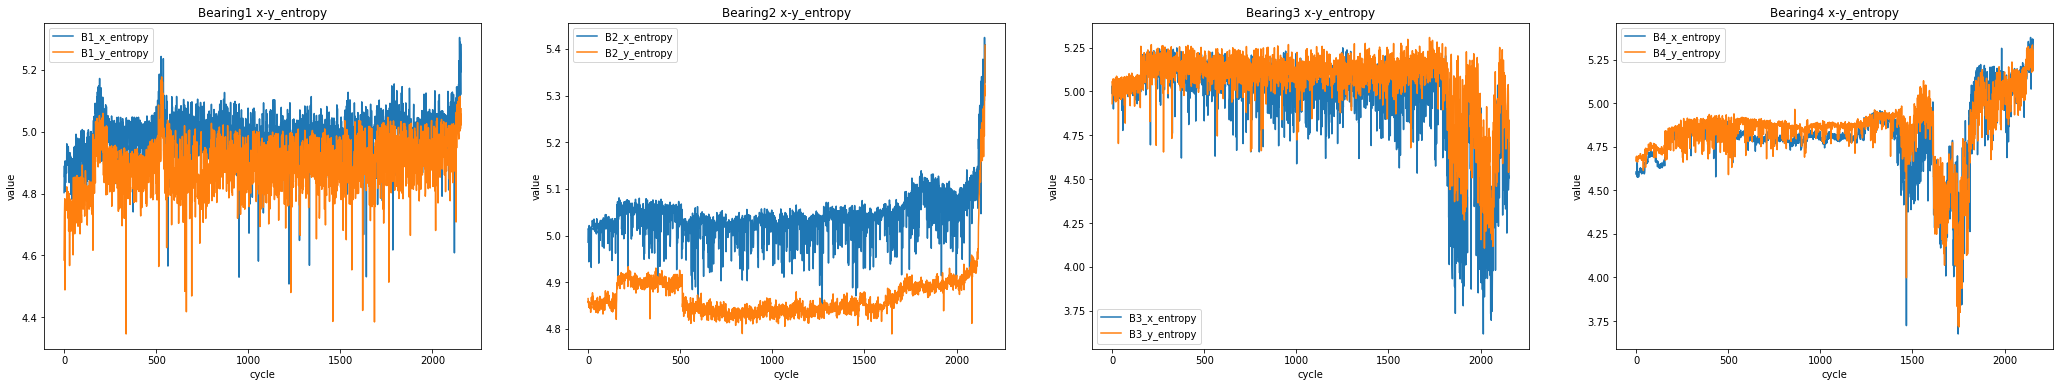

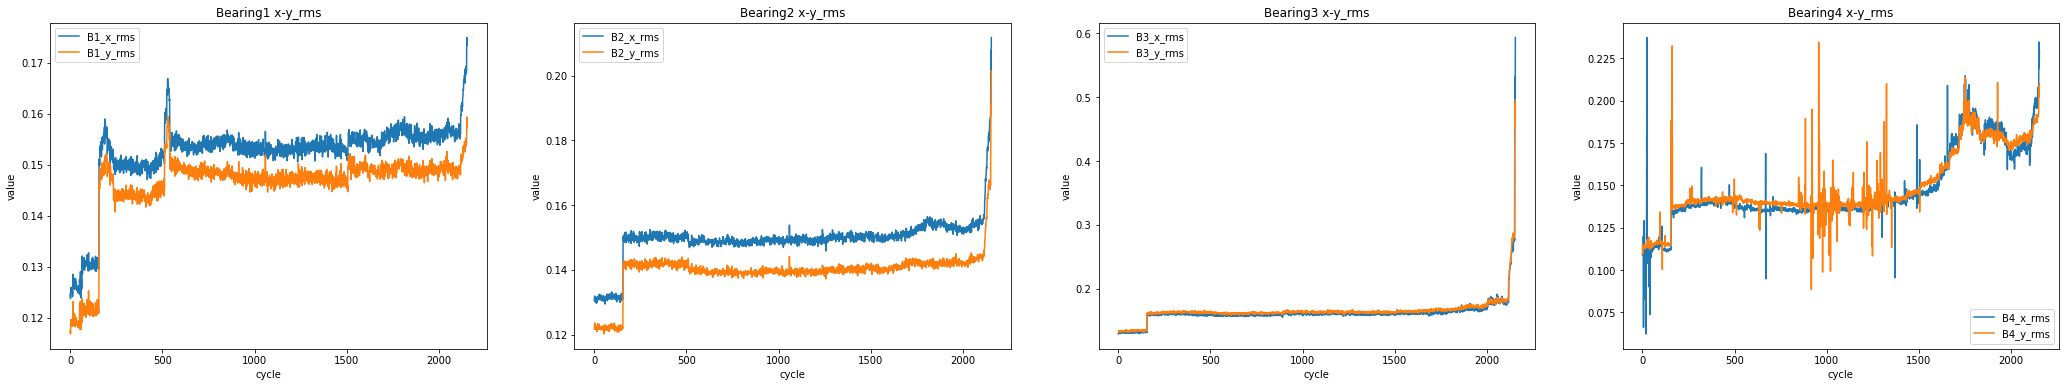

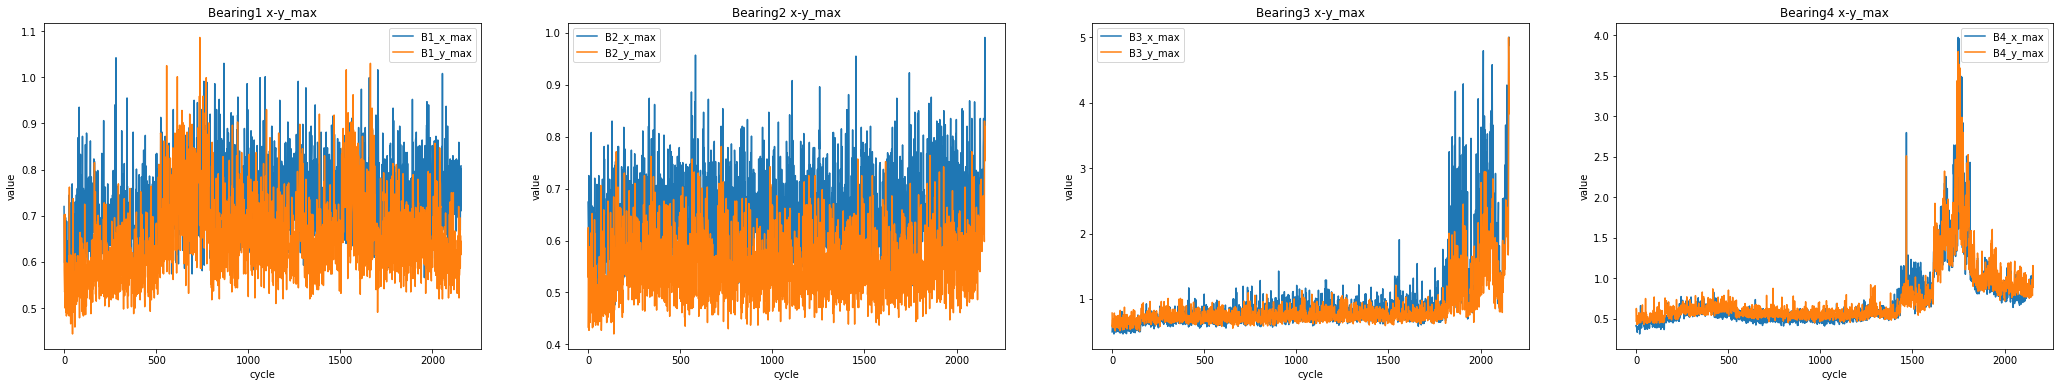

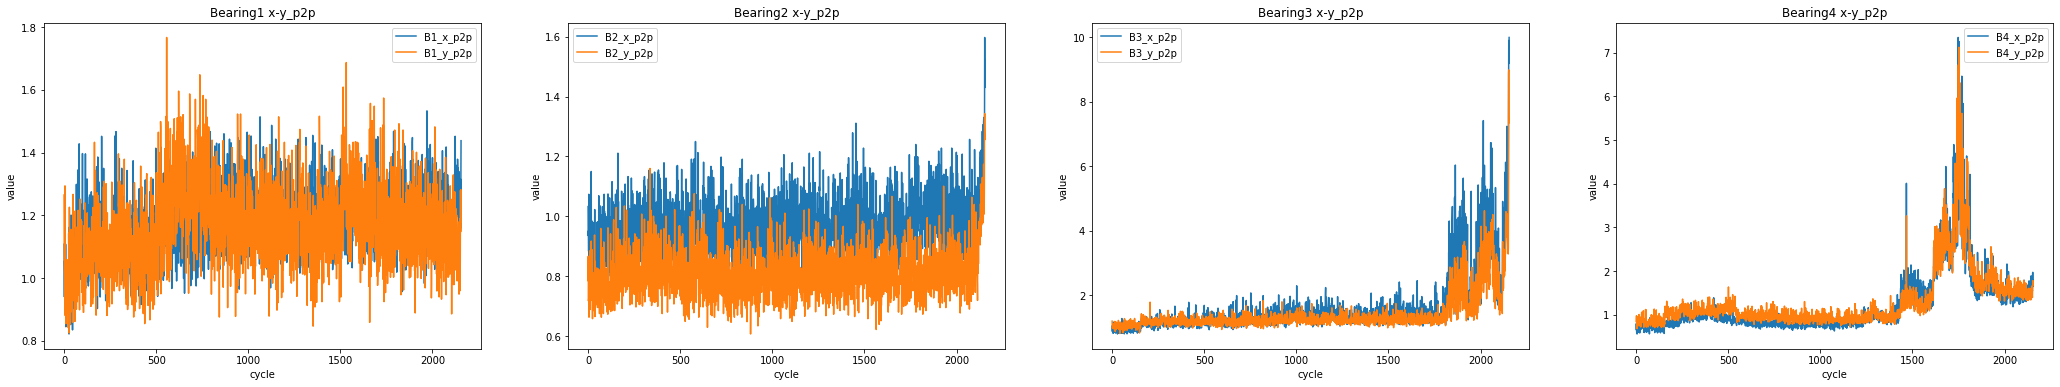

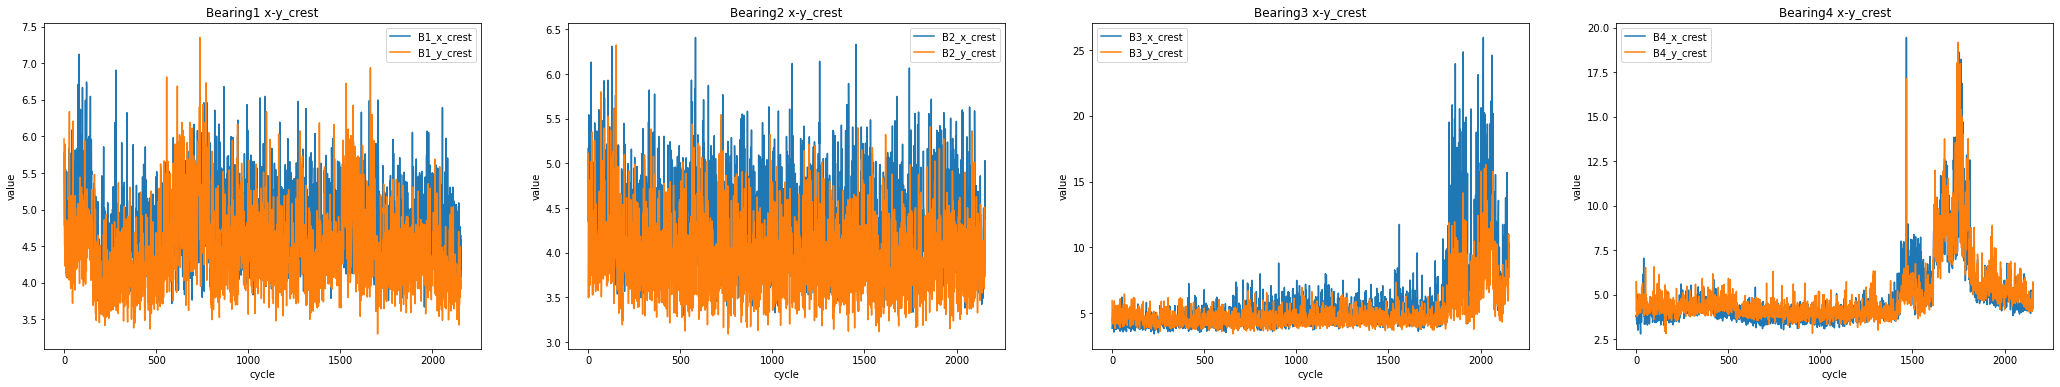

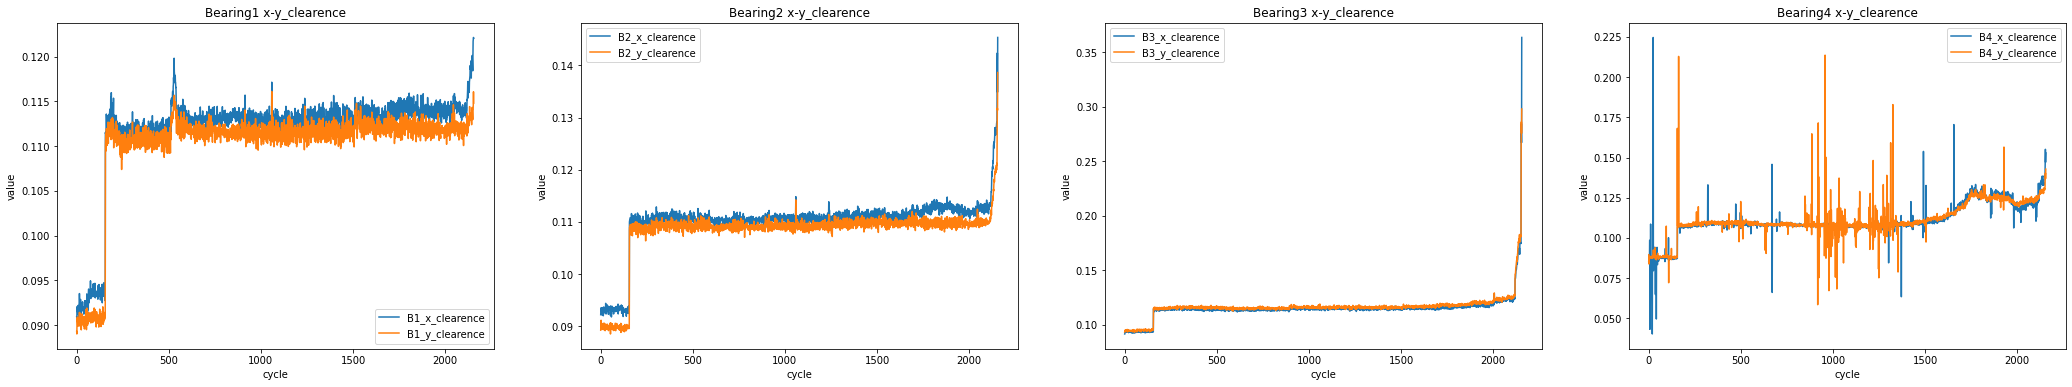

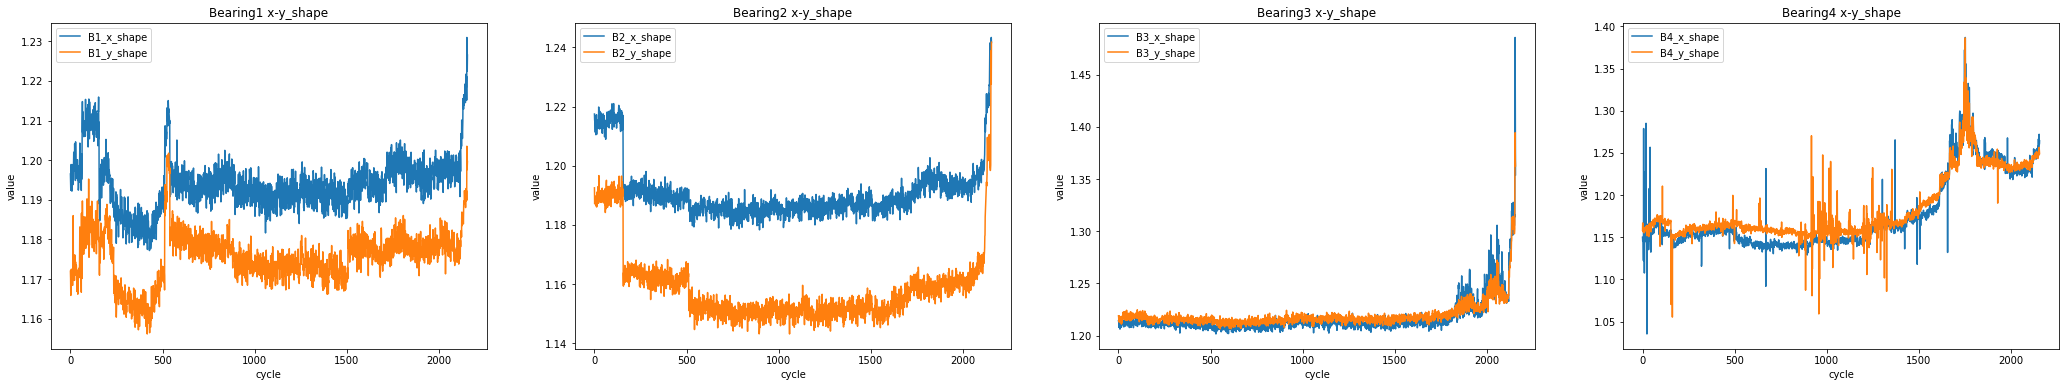

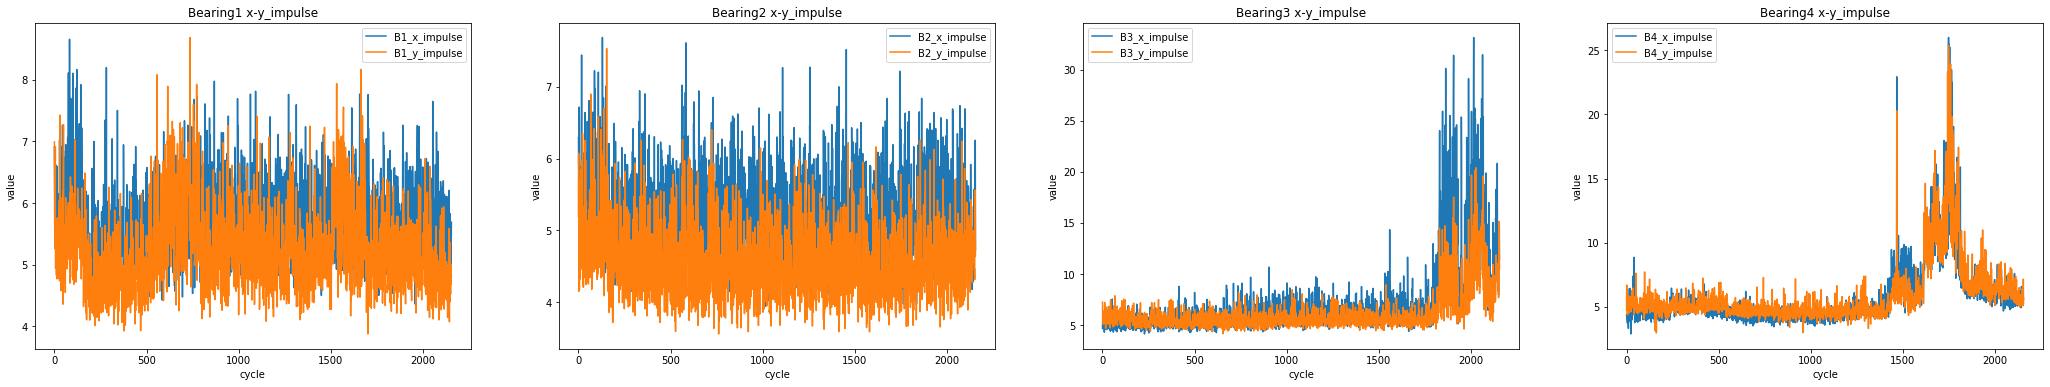

In [8]:
time_features_list = ["mean","std","skew","kurtosis","entropy","rms","max","p2p", "crest", "clearence", "shape", "impulse"]
bearings_xy = [["B"+str(n)+"_"+str(o)+"_" for n in range(1,5)] for o in ['x','y'] ] 
#print(bearings_xy)
for tf in time_features_list:
    fig = plt.figure()
    # Divide the figure into a 1x4 grid, and give me the first section
    ax1 = fig.add_subplot(141)
    # Divide the figure into a 1x4 grid, and give me the second section
    ax2 = fig.add_subplot(142)
    #...so on
    ax3 = fig.add_subplot(143)
    ax4 = fig.add_subplot(144)
    axes = [ax1,ax2,ax3, ax4]
    
    for i in range(4):
        col = bearings_xy[0][i]+tf
        set1[col].plot(figsize = (36,6), title="Bearing{} x-y_".format(i+1)+tf , legend = True, ax=axes[i])
        col = bearings_xy[1][i]+tf
        set1[col].plot(figsize = (36,6) , legend = True, ax=axes[i])
        axes[i].set(xlabel="cycle", ylabel="value")
        
    
    

In [9]:
#Health Status labels are added according to following dictionary
B1 ={
    "early" : ["2003-10-22 12:06:24" , "2003-10-23 09:14:13"],
    "suspect" : ["2003-10-23 09:24:13" , "2003-11-08 12:11:44"],
    "normal" : ["2003-11-08 12:21:44" , "2003-11-19 21:06:07"],
    "suspect_1" : ["2003-11-19 21:16:07" , "2003-11-24 20:47:32"],
    "imminent_failure" : ["2003-11-24 20:57:32","2003-11-25 23:39:56"]
}
B2 = {
    "early" : ["2003-10-22 12:06:24" , "2003-11-01 21:41:44"],
    "normal" : ["2003-11-01 21:51:44" , "2003-11-24 01:01:24"],
    "suspect" : ["2003-11-24 01:11:24" , "2003-11-25 10:47:32"],
    "imminient_failure" : ["2003-11-25 10:57:32" , "2003-11-25 23:39:56"]
}

B3 = {
    "early" : ["2003-10-22 12:06:24" , "2003-11-01 21:41:44"],
    "normal" : ["2003-11-01 21:51:44" , "2003-11-22 09:16:56"],
    "suspect" : ["2003-11-22 09:26:56" , "2003-11-25 10:47:32"],
    "Inner_race_failure" : ["2003-11-25 10:57:32" , "2003-11-25 23:39:56"]
}

B4 = {
    "early" : ["2003-10-22 12:06:24" , "2003-10-29 21:39:46"],
    "normal" : ["2003-10-29 21:49:46" , "2003-11-15 05:08:46"],
    "suspect" : ["2003-11-15 05:18:46" , "2003-11-18 19:12:30"],
    "Rolling_element_failure" : ["2003-11-19 09:06:09" , "2003-11-22 17:36:56"],
    "Stage_two_failure" : ["2003-11-22 17:46:56" , "2003-11-25 23:39:56"]
}


Adding labels to the dataframe

In [10]:
B1_state = list()
B2_state = list()
B3_state = list()
B4_state = list()
cnt = 0

for row in set1["time"]:
    cnt += 1
    # B1
    if cnt<=151:
        B1_state.append("early")
    if 151 < cnt <=600:
        B1_state.append("suspect")
    if 600 < cnt <=1499:
        B1_state.append("normal")
    if 1499 < cnt <=2098:
        B1_state.append("suspect")
    if 2098 < cnt <= 2156:
        B1_state.append("imminent_failure")
    #B2
    if cnt<=500:
        B2_state.append("early")
    if 500 < cnt <=2000:
        B2_state.append("normal")
    if 2000 < cnt <=2120:
        B2_state.append("suspect")
    if 2120< cnt <=2156:
        B2_state.append("imminet_failure")

    #B3
    if cnt<=500:
        B3_state.append("early")
    if 500 < cnt <= 1790:
        B3_state.append("normal")
    if 1790 < cnt <=2120:
        B3_state.append("suspect")
    if 2120 < cnt <=2156:
        B3_state.append("Inner_race_failure")
    #B4
    if cnt<=200:
        B4_state.append("early")
    if 200 < cnt <=1000:
        B4_state.append("normal")
    if 1000 < cnt <= 1435:
        B4_state.append("suspect")
    if 1435 < cnt <=1840:
        B4_state.append("Inner_race_failure")
    if 1840 < cnt <=2156:
        B4_state.append("Stage_two_failure")
#controlling the counts
from collections import Counter
print(Counter(B1_state))
print(Counter(B2_state))
print(Counter(B3_state))
print(Counter(B4_state))

set1["B1_state"] = B1_state
set1["B2_state"] = B2_state
set1["B3_state"] = B3_state
set1["B4_state"] = B4_state

set1.head()

Counter({'suspect': 1048, 'normal': 899, 'early': 151, 'imminent_failure': 58})
Counter({'normal': 1500, 'early': 500, 'suspect': 120, 'imminet_failure': 36})
Counter({'normal': 1290, 'early': 500, 'suspect': 330, 'Inner_race_failure': 36})
Counter({'normal': 800, 'suspect': 435, 'Inner_race_failure': 405, 'Stage_two_failure': 316, 'early': 200})


,time,B1_x_mean,B1_x_std,B1_x_skew,B1_x_kurtosis,B1_x_entropy,B1_x_rms,B1_x_max,B1_x_p2p,B1_x_crest,...,B4_y_max,B4_y_p2p,B4_y_crest,B4_y_clearence,B4_y_shape,B4_y_impulse,B1_state,B2_state,B3_state,B4_state
0,2003-10-22 12:06:24,0.104148,0.081124,-0.029900,1.069800,4.803057,0.124617,0.720,1.108,5.777714,...,0.471,0.845,4.086202,0.089551,1.158299,4.733045,early,early,early,early
1,2003-10-22 12:09:13,0.103651,0.079519,-0.070118,1.161960,4.844846,0.123812,0.654,1.042,5.282223,...,0.627,0.900,5.741234,0.083762,1.166936,6.699653,early,early,early,early
2,2003-10-22 12:14:13,0.105039,0.080220,-0.041579,0.986724,4.889311,0.125249,0.623,0.940,4.974097,...,0.601,0.977,5.286066,0.088436,1.156631,6.114027,early,early,early,early
3,2003-10-22 12:19:13,0.104900,0.080828,0.005235,1.034758,4.852691,0.125200,0.598,1.055,4.776357,...,0.525,0.852,4.588565,0.088515,1.160373,5.324447,early,early,early,early
4,2003-10-22 12:24:13,0.104779,0.082038,-0.060123,1.110658,4.889993,0.125621,0.623,1.011,4.959370,...,0.522,0.871,4.568532,0.088455,1.160343,5.301063,early,early,early,early


Splitting each bearing data and adding them end to end vertically

In [11]:
B1_cols = [col for col in set1.columns if "B1" in col]
B2_cols = [col for col in set1.columns if "B2" in col]
B3_cols = [col for col in set1.columns if "B3" in col]
B4_cols = [col for col in set1.columns if "B4" in col]

B1 = set1[B1_cols]
B2 = set1[B2_cols]
B3 = set1[B3_cols]
B4 = set1[B4_cols]
cols = ['Bx_mean','Bx_std','Bx_skew','Bx_kurtosis','Bx_entropy','Bx_rms','Bx_max','Bx_p2p','Bx_crest', 'Bx_clearence', 'Bx_shape', 'Bx_impulse',
        'By_mean','By_std','By_skew','By_kurtosis','By_entropy','By_rms','By_max','By_p2p','By_crest', 'By_clearence', 'By_shape', 'By_impulse',
        'class']
B1.columns = cols
B2.columns = cols
B3.columns = cols
B4.columns = cols
final_data = pd.concat([B1,B2,B3,B4], axis=0, ignore_index=True)
final_data.describe()

,Bx_mean,Bx_std,Bx_skew,Bx_kurtosis,Bx_entropy,Bx_rms,Bx_max,Bx_p2p,Bx_crest,Bx_clearence,...,By_skew,By_kurtosis,By_entropy,By_rms,By_max,By_p2p,By_crest,By_clearence,By_shape,By_impulse
count,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,...,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000
mean,0.127560,0.100044,-0.024981,1.334116,4.946657,0.152591,0.768281,1.245925,4.944205,0.111824,...,0.012316,1.125540,4.915563,0.149746,0.701041,1.175864,4.606731,0.111392,1.184353,5.481094
std,0.011487,0.021102,0.106187,3.340440,0.195089,0.017037,0.380306,0.658757,1.868630,0.008977,...,0.068697,1.907041,0.164481,0.017631,0.290447,0.532997,1.337560,0.009314,0.030823,1.752930
min,0.048434,0.058210,-2.542674,-0.060380,3.617485,0.062243,0.312000,0.559000,2.790208,0.040238,...,-1.052182,0.045386,3.715214,0.088486,0.420000,0.608000,2.815276,0.058448,1.055297,2.970951
25%,0.124932,0.091431,-0.058129,0.375305,4.879786,0.148059,0.608000,0.940000,4.115825,0.109906,...,-0.029428,0.457801,4.841772,0.140119,0.557000,0.881000,3.942587,0.109000,1.159891,4.615805
50%,0.128211,0.097648,-0.027155,0.806083,5.005758,0.152825,0.693000,1.106000,4.535037,0.112462,...,0.005879,0.767156,4.892254,0.146617,0.627000,1.096000,4.292514,0.110999,1.175230,5.076103
75%,0.131489,0.110512,0.009014,1.124327,5.053243,0.158982,0.789000,1.286250,5.061653,0.114305,...,0.051146,1.219306,5.011436,0.161695,0.732000,1.252000,4.784112,0.115241,1.214024,5.701873
max,0.438427,0.579446,2.157247,71.578220,5.424562,0.593624,5.000000,9.998000,25.948185,0.363341,...,1.076577,56.379136,5.408023,0.496012,5.000000,8.992000,19.173531,0.297790,1.394270,25.364433


Train-Test Split (70%-30%)

In [12]:
X = final_data.copy()
y = X.pop("class")
le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state =1)

Evaluating Performance of Base Models

In [13]:
xgb_cl = xgb.XGBClassifier(use_label_encoder=False)
xgb_cl.fit(X_train, y_train)
preds = xgb_cl.predict(X_test)
accuracy_score(y_test, preds)

[22:01:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8879443585780525

**From now on, only X axis data will be used**
                                                                                                                          
So data acquired from y axis will be excluded  

In [14]:
x_axis_cols = ["Bx_"+tf for tf in time_features_list]
print(x_axis_cols)
X_x = X.copy()
X_x = X[x_axis_cols]
cols = ['B_mean','B_std','B_skew','B_kurtosis','B_entropy',
        'B_rms','B_max','B_p2p','B_crest', 'B_clearence', 'B_shape', 'B_impulse']
X_x.columns = cols
X_x_train, X_x_test, y_train, y_test = train_test_split(X_x, y, test_size = 0.3, random_state =1)

['Bx_mean', 'Bx_std', 'Bx_skew', 'Bx_kurtosis', 'Bx_entropy', 'Bx_rms', 'Bx_max', 'Bx_p2p', 'Bx_crest', 'Bx_clearence', 'Bx_shape', 'Bx_impulse']


# Model Selection

Now we can compare several learning algorithms

In [15]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", 
         #"Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA","XGBoost","CatGBoost","LightGBoost"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    xgb.XGBClassifier(),
    cb.CatBoostClassifier(verbose = False),
    lgbm.LGBMClassifier()
    ]

for name, clf in zip(names,classifiers):
    print("training "+name+" ...")
    clf.fit(X_x_train,y_train)
    score = clf.score(X_x_test,y_test)
    print('Score of'+name+' is: '+str(score))
    #iterate over classifiers
    

training Nearest Neighbors ...
Score ofNearest Neighbors is: 0.7156105100463679
training Linear SVM ...
Score ofLinear SVM is: 0.5691653786707882
training RBF SVM ...
Score ofRBF SVM is: 0.7187017001545595
training Decision Tree ...
Score ofDecision Tree is: 0.731839258114374
training Random Forest ...
Score ofRandom Forest is: 0.6877897990726429
training Neural Net ...
Score ofNeural Net is: 0.6387171561051005
training AdaBoost ...
Score ofAdaBoost is: 0.597758887171561
training Naive Bayes ...
Score ofNaive Bayes is: 0.5467542503863988
training QDA ...
Score ofQDA is: 0.6796754250386399
training XGBoost ...


/opt/conda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:02:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Score ofXGBoost is: 0.8423493044822257
training CatGBoost ...
Score ofCatGBoost is: 0.8438948995363215
training LightGBoost ...
Score ofLightGBoost is: 0.8411901081916537


# Hyperparameter Tuning
* Since accuracy score of the last 3 base model,namely XGBoost,CatBoost, LightBoost, are the highest ones, we will continue with one of them in further investigations  
* Parameters of the selected model will be tuned with optuna library
* Typical values were given as interval of parameters

In [16]:
def objective(trial):
    xgb_params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 10),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
        )
    xgb_cl = xgb.XGBClassifier(
            booster='gbtree',
            tree_method ='gpu_hist',
            use_label_encoder=False,
            **xgb_params)
    xgb_cl.fit(X_x_train, y_train)
    preds = xgb_cl.predict(X_x_test)
    accuracy_score(y_test, preds)
    return accuracy_score(y_test,preds)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
xgb_params = study.best_params

[I 2021-10-06 22:02:32,336] A new study created in memory with name: no-name-b751b975-49e3-4729-9035-6ab206668332


[22:02:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-10-06 22:03:12,981] Trial 0 finished with value: 0.8342349304482226 and parameters: {'max_depth': 3, 'learning_rate': 0.0015175931399875665, 'n_estimators': 6734, 'min_child_weight': 7, 'colsample_bytree': 0.43394241306359593, 'subsample': 0.2974790714655815, 'reg_alpha': 1.0485833462084824, 'reg_lambda': 0.044347806934224174}. Best is trial 0 with value: 0.8342349304482226.


[22:03:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-10-06 22:03:53,449] Trial 1 finished with value: 0.8415765069551777 and parameters: {'max_depth': 7, 'learning_rate': 0.010374936399406206, 'n_estimators': 4221, 'min_child_weight': 5, 'colsample_bytree': 0.5045696539854649, 'subsample': 0.6868758975052911, 'reg_alpha': 0.001489655657239012, 'reg_lambda': 0.00010155575914237831}. Best is trial 1 with value: 0.8415765069551777.


[22:03:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-10-06 22:04:30,240] Trial 2 finished with value: 0.8319165378670789 and parameters: {'max_depth': 2, 'learning_rate': 0.08278534180894306, 'n_estimators': 7730, 'min_child_weight': 3, 'colsample_bytree': 0.29732040978911184, 'subsample': 0.8288451756662516, 'reg_alpha': 0.8094932722470033, 'reg_lambda': 0.021017263828629066}. Best is trial 1 with value: 0.8415765069551777.


[22:04:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-10-06 22:04:50,508] Trial 3 finished with value: 0.6275115919629057 and parameters: {'max_depth': 6, 'learning_rate': 0.0889699467629815, 'n_estimators': 5216, 'min_child_weight': 7, 'colsample_bytree': 0.4523354707022346, 'subsample': 0.2038894241938893, 'reg_alpha': 64.98410933736248, 'reg_lambda': 0.10122343445478786}. Best is trial 1 with value: 0.8415765069551777.


[22:04:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-10-06 22:05:09,245] Trial 4 finished with value: 0.6553323029366306 and parameters: {'max_depth': 2, 'learning_rate': 0.0002136298906722199, 'n_estimators': 3535, 'min_child_weight': 4, 'colsample_bytree': 0.5839291372119633, 'subsample': 0.7607419752652917, 'reg_alpha': 41.34679434137571, 'reg_lambda': 0.00020269365829777856}. Best is trial 1 with value: 0.8415765069551777.


[22:05:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-10-06 22:06:00,249] Trial 5 finished with value: 0.6700154559505409 and parameters: {'max_depth': 9, 'learning_rate': 0.0002981060951461548, 'n_estimators': 7235, 'min_child_weight': 3, 'colsample_bytree': 0.3951756657052199, 'subsample': 0.5096269742996432, 'reg_alpha': 53.7686981369868, 'reg_lambda': 61.91956615619116}. Best is trial 1 with value: 0.8415765069551777.


[22:06:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-10-06 22:06:36,213] Trial 6 finished with value: 0.8380989180834622 and parameters: {'max_depth': 5, 'learning_rate': 0.03185517882663267, 'n_estimators': 4145, 'min_child_weight': 1, 'colsample_bytree': 0.6144556011801862, 'subsample': 0.9986352871650166, 'reg_alpha': 0.16245885776176738, 'reg_lambda': 0.0007287476624792397}. Best is trial 1 with value: 0.8415765069551777.


[22:06:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-10-06 22:06:58,907] Trial 7 finished with value: 0.6773570324574961 and parameters: {'max_depth': 2, 'learning_rate': 0.00013781042632523364, 'n_estimators': 4641, 'min_child_weight': 6, 'colsample_bytree': 0.8002323201799442, 'subsample': 0.5369695532146017, 'reg_alpha': 0.0020369025895096257, 'reg_lambda': 0.0058545929936405115}. Best is trial 1 with value: 0.8415765069551777.


[22:06:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-10-06 22:08:17,964] Trial 8 finished with value: 0.8257341576506955 and parameters: {'max_depth': 6, 'learning_rate': 0.00013225128140653336, 'n_estimators': 6312, 'min_child_weight': 5, 'colsample_bytree': 0.819045300484339, 'subsample': 0.4666506088933101, 'reg_alpha': 0.0034523415492046564, 'reg_lambda': 0.0007789996643954398}. Best is trial 1 with value: 0.8415765069551777.


[22:08:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-10-06 22:08:48,415] Trial 9 finished with value: 0.6750386398763524 and parameters: {'max_depth': 2, 'learning_rate': 0.009836889370246536, 'n_estimators': 7769, 'min_child_weight': 5, 'colsample_bytree': 0.903912105420835, 'subsample': 0.22864565889233734, 'reg_alpha': 44.08912926917018, 'reg_lambda': 0.001041036965542296}. Best is trial 1 with value: 0.8415765069551777.


[22:08:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-10-06 22:09:03,754] Trial 10 finished with value: 0.839644513137558 and parameters: {'max_depth': 9, 'learning_rate': 0.003200388746484734, 'n_estimators': 1150, 'min_child_weight': 10, 'colsample_bytree': 0.6518427586293252, 'subsample': 0.7009404568458862, 'reg_alpha': 0.000334607711815471, 'reg_lambda': 1.6384160116893087}. Best is trial 1 with value: 0.8415765069551777.


[22:09:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-10-06 22:09:20,284] Trial 11 finished with value: 0.8357805255023184 and parameters: {'max_depth': 9, 'learning_rate': 0.0024628932654317055, 'n_estimators': 1176, 'min_child_weight': 10, 'colsample_bytree': 0.6428237668718236, 'subsample': 0.702109866555976, 'reg_alpha': 0.0001085140272512857, 'reg_lambda': 2.7471686185423834}. Best is trial 1 with value: 0.8415765069551777.


[22:09:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-10-06 22:09:34,416] Trial 12 finished with value: 0.847758887171561 and parameters: {'max_depth': 10, 'learning_rate': 0.007656195406468542, 'n_estimators': 1068, 'min_child_weight': 10, 'colsample_bytree': 0.7218306470888919, 'subsample': 0.646169940518253, 'reg_alpha': 0.00011440995932821993, 'reg_lambda': 0.9098741936931949}. Best is trial 12 with value: 0.847758887171561.


[22:09:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-10-06 22:10:02,264] Trial 13 finished with value: 0.839258114374034 and parameters: {'max_depth': 10, 'learning_rate': 0.012091115229970003, 'n_estimators': 2621, 'min_child_weight': 8, 'colsample_bytree': 0.996119354804075, 'subsample': 0.8936459209549035, 'reg_alpha': 0.0055214248518045, 'reg_lambda': 0.863534594028209}. Best is trial 12 with value: 0.847758887171561.


[22:10:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-10-06 22:10:29,959] Trial 14 finished with value: 0.8493044822256569 and parameters: {'max_depth': 8, 'learning_rate': 0.006631431803688388, 'n_estimators': 2471, 'min_child_weight': 8, 'colsample_bytree': 0.7428669791509737, 'subsample': 0.6084144888892333, 'reg_alpha': 0.0006779727308495099, 'reg_lambda': 38.7444625903542}. Best is trial 14 with value: 0.8493044822256569.


[22:10:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-10-06 22:10:46,124] Trial 15 finished with value: 0.7299072642967542 and parameters: {'max_depth': 8, 'learning_rate': 0.0011178829251543578, 'n_estimators': 2224, 'min_child_weight': 9, 'colsample_bytree': 0.7606134107304581, 'subsample': 0.3830521873853778, 'reg_alpha': 0.024123296537426998, 'reg_lambda': 75.35409171523362}. Best is trial 14 with value: 0.8493044822256569.


[22:10:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-10-06 22:11:16,113] Trial 16 finished with value: 0.8493044822256569 and parameters: {'max_depth': 10, 'learning_rate': 0.004779403951378455, 'n_estimators': 2450, 'min_child_weight': 9, 'colsample_bytree': 0.7064144845892498, 'subsample': 0.577248965869814, 'reg_alpha': 0.00012515110787970148, 'reg_lambda': 19.940477404019052}. Best is trial 14 with value: 0.8493044822256569.


[22:11:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-10-06 22:11:49,313] Trial 17 finished with value: 0.8334621329211747 and parameters: {'max_depth': 8, 'learning_rate': 0.0007560691086708349, 'n_estimators': 2985, 'min_child_weight': 8, 'colsample_bytree': 0.9068395851062117, 'subsample': 0.5935707015422035, 'reg_alpha': 0.0005249104357678223, 'reg_lambda': 8.807688936072095}. Best is trial 14 with value: 0.8493044822256569.


[22:11:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-10-06 22:12:10,318] Trial 18 finished with value: 0.8408037094281299 and parameters: {'max_depth': 8, 'learning_rate': 0.004731605419024274, 'n_estimators': 2005, 'min_child_weight': 8, 'colsample_bytree': 0.7107649141519549, 'subsample': 0.4124993628617746, 'reg_alpha': 0.021203635949794977, 'reg_lambda': 18.153099757939508}. Best is trial 14 with value: 0.8493044822256569.


[22:12:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-10-06 22:12:31,718] Trial 19 finished with value: 0.8438948995363215 and parameters: {'max_depth': 4, 'learning_rate': 0.027464225413296003, 'n_estimators': 3202, 'min_child_weight': 7, 'colsample_bytree': 0.5369968913286259, 'subsample': 0.5899525956916079, 'reg_alpha': 0.0005591828048887737, 'reg_lambda': 13.156164379812129}. Best is trial 14 with value: 0.8493044822256569.


Final XGBoost parameters were obtained by hyperparametertuning using GPU but final model should be trained by CPU to get possibly better result                                             


In [17]:
final_model = xgb.XGBClassifier(use_label_encoder=False,
                                **xgb_params)
final_model.fit(X_x_train, y_train)
preds = final_model.predict(X_x_test)
accuracy_score(y_test, preds)
#performance is increased

[22:12:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8512364760432767

Loading Dataset 2 and 3 to observe the result of the final model on them


In [18]:
set2 = time_features(dataset_path_2nd, id_set=2)
set2.to_csv('set2_timefeatures.csv')
set3 = time_features(dataset_path_3rd, id_set=3)
set3.to_csv('set3_timefeatures.csv')

In [19]:
set2 = pd.read_csv("./set2_timefeatures.csv")
set3 = pd.read_csv("./set3_timefeatures.csv")
time_2 = set2['Unnamed: 0']
#Setting index columns to time
set2 = set2.rename(columns={'Unnamed: 0':'time'}).set_index('time')
set3 = set3.rename(columns={'Unnamed: 0':'time'}).set_index('time')

Vertically splitting bearing datum to obtain each bearings' data seperately

In [20]:
B1_cols = [col for col in set2.columns if "B1" in col]
B2_cols = [col for col in set2.columns if "B2" in col]
B3_cols = [col for col in set2.columns if "B3" in col]
B4_cols = [col for col in set2.columns if "B4" in col]

set2_B1 = set2[B1_cols]
set2_B2 = set2[B2_cols]
set2_B3 = set2[B3_cols]
set2_B4 = set2[B4_cols]

set3_B1 = set3[B1_cols]
set3_B2 = set3[B2_cols]
set3_B3 = set3[B3_cols]
set3_B4 = set3[B4_cols]

set2_B1.columns = cols
set2_B2.columns = cols
set2_B3.columns = cols
set2_B4.columns = cols
set3_B1.columns = cols
set3_B2.columns = cols
set3_B3.columns = cols
set3_B4.columns = cols


# Results
Here, we using plotly library which is more useful than matplotlib in terms of interactivity                   
Extracted features are plotted with their "health state" label

In [21]:
# HERE number and dataset of bearing can be changed !!!
bearing = set2_B1

#predicting state of bearing with final_model
preds = final_model.predict(bearing)
preds = le.inverse_transform(preds)
#inserting prediction and time to the dataframe
bearing.insert(12,'state',preds)
bearing.insert(13, 'time',bearing.index)

for tf in time_features_list:
    col = "B_{}".format(tf)
    print(col)
    fig=go.Figure((go.Scatter(x=bearing['time'], y=bearing[col],
                             mode='lines',
                             line=dict(color='rgba(0,0,220,0.8)'))))
    fig.add_traces(px.scatter(bearing, x='time', y=col, color='state').data)
    fig.update_layout(template='plotly_dark')
    fig.update_xaxes(showgrid=False)
    fig.show()
    

B_mean


B_std


B_skew


B_kurtosis


B_entropy


B_rms


B_max


B_p2p


B_crest


B_clearence


B_shape


B_impulse


# Conclusion
It seems that trained model is not realiable on other datasets when it comes to classification of the type of the fault with this type of approach. However, the trained model can distinguish whether the data sourced from healty or faulty bearing when considering "early" and "normal" states as healty. Morever, although it is not mentioned above, feature evaluation and selection process has been conducted on the extracted features with respect to average of the following three metrics, correlation,monotonicity,robustness[3]. It is observed that when the feature which have minimum value of metric defined in the study exculeded from the features dataframe, performance of the model decreased. In further works,contary the this study vibration data can be regarded as time series data and deep learing methods, especially RNNs can be utilized. Also, frequency based feature can be extracted and advanced feature engineering methods can be applied to increase the performance of the model. 

# References
1. https://www.kaggle.com/yasirabd/nasa-bearing-feature-extraction
2. https://www.mathworks.com/help/predmaint/ug/signal-features.html
3. https://www.mdpi.com/2076-3417/10/16/5639/htm#B13-applsci-10-05639


# Additional Resources
1. https://www.youtube.com/watch?v=YtebGVx-Fxw&list=RDCMUCtYLUTtgS3k1Fg4y5tAhLbw&start_radio=1
2. Cavalaglio Camargo Molano, J., Strozzi, M., Rubini, R., & Cocconcelli, M. (2019). Analysis of NASA Bearing Dataset of the University of Cincinnati by Means of Hjorth’s Parameters. In International Conference on Structural Engineering Dynamics ICEDyn 2019.

**NOTE**                                                                                                       
This work is carried out during my Data Science Internship in SensHero Predictive Maintenance Solutions
* In the first week general knowledge about rotary machines and bearings acquired and the literature about the dataset was reviewed.
* In the second week several methods are applied and the code rectified with respect to feedbacks